# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
cifar10_dir = './cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



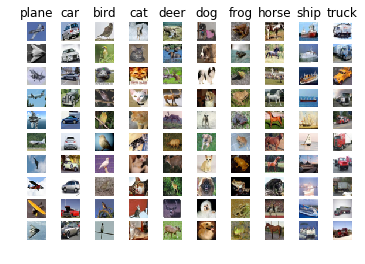

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

Так как load_CIFAR10 при выгрузке изображений уже перемешивает классы, просто возьмём несколько объектов из начала (исходных изображений довольно много, возьмём только часть из них).

In [4]:
num_training = 7000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [6]:
from scripts.classifiers.k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [7]:
y_pred = classifier.predict(X_test)

# сравним несколько результатов из начала (результат не очень, конечно)
print('Predictions: ', y_pred[:10])
print('True labels: ', y_test[:10])

Predictions:  [4. 9. 8. 8. 4. 4. 3. 2. 5. 8.]
True labels:  [3 8 8 0 6 6 1 6 3 1]


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


In [8]:
dists = classifier.compute_distances_no_loops(X_test)

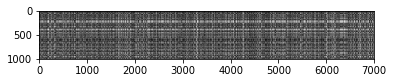

In [9]:
plt.imshow(dists, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [10]:
y_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct and total accuracy: %f' % (num_correct, num_test, accuracy))

Got 268 / 1000 correct and total accuracy: 0.268000


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

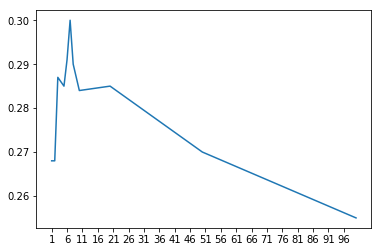

In [11]:
accuracies = []
ks = [1, 2, 3, 5, 6, 7, 8, 10, 20, 50, 100]
for k in ks:
    y_pred = classifier.predict_labels(dists, k=k)
    num_correct = np.sum(y_pred == y_test)
    accuracy = float(num_correct) / num_test
    
    accuracies.append(accuracy)
    
plt.plot(ks, accuracies)
plt.xticks(range(1, 101, 5));

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [12]:
num_folds = 5
x_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

accuracies = np.zeros((num_folds, len(ks)))
# строки - фолды, столбцы - количество соседей                    
for i in range(num_folds):
    x_test_fold = x_train_folds[i]
    y_test_fold = y_train_folds[i]

    x_train_fold = np.concatenate(x_train_folds[:i]+x_train_folds[i+1:])
    y_train_fold = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])

    classifier.train(x_train_fold, y_train_fold)
    dists_fold = classifier.compute_distances_no_loops(x_test_fold)
    for j, k in enumerate(ks):
        y_test_pred = classifier.predict_labels(dists_fold, k)
        num_correct = np.sum(y_test_pred == y_test_fold)
        accuracy = float(num_correct) /y_test_fold.shape[0]
        accuracies[i, j] = accuracy

In [13]:
best_k = ks[np.argmax(np.mean(accuracies, axis=0))]
best_k

20

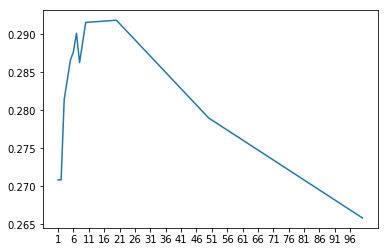

In [14]:
plt.plot(ks, np.mean(accuracies, axis=0))
plt.xticks(range(1, 101, 5));


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [15]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

y_pred = classifier.predict_labels(dists, k=best_k)

num_correct = np.sum(y_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct and total accuracy: %f' % (num_correct, num_test, accuracy))

Got 285 / 1000 correct and total accuracy: 0.285000


1.11 Сделайте выводы по результатам 1 части задания.

Классификатор KNN довольно прост в построении и понимании, но при этом его точность далека от совершенства (менее 30%). 

Подбор оптимального параметра (числа соседей) с помощью кросс-валидации позволяет немного улучшить качество по сравнению с классификатором по умолчанию (1 сосед).

## 2.  Классификация данных методом опорных векторов (SVM)

Эту часть задания я попыталась выполнить из любопытства.

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [16]:
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

Clear previously loaded data.


In [17]:
num_training = 7000

num_val = 1000
mask = list(range(num_training, num_training + num_val))
X_val = X_train[mask]
y_val = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

num_dev = 1000
mask = list(range(num_training + num_val, num_training + num_val + num_dev))
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее 1.

[131.39442857 136.34471429 132.72142857 130.785      135.73842857
 132.04557143 131.69471429 136.53728571 132.73171429 132.672     ]


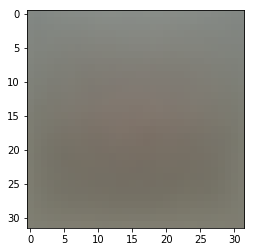

(7000, 3073) (1000, 3073) (1000, 3073)


In [19]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [20]:
from scripts.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.561265



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [21]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -14.459000 analytic: -14.459000, relative error: 1.343730e-11
numerical: 22.071951 analytic: 22.136000, relative error: 1.448820e-03
numerical: 14.103000 analytic: 14.103000, relative error: 4.413270e-11
numerical: 18.317000 analytic: 18.317000, relative error: 5.730077e-12
numerical: 60.667000 analytic: 60.667000, relative error: 1.572360e-13
numerical: -75.447163 analytic: -75.404000, relative error: 2.861285e-04
numerical: 8.092000 analytic: 8.092000, relative error: 5.326184e-11
numerical: 23.353626 analytic: 23.458000, relative error: 2.229656e-03
numerical: 21.073000 analytic: 21.073000, relative error: 3.360470e-11
numerical: -6.821156 analytic: -6.860000, relative error: 2.839200e-03
numerical: 37.680155 analytic: 37.680155, relative error: 1.157889e-11
numerical: 23.848965 analytic: 23.782141, relative error: 1.402959e-03
numerical: 31.222524 analytic: 31.222524, relative error: 3.937879e-12
numerical: 30.521653 analytic: 30.485940, relative error: 5.853802e-04
nume

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [22]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.271169s
Vectorized loss and gradient: computed in 0.030859s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [23]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.882331
iteration 100 / 1500: loss 287.410514
iteration 200 / 1500: loss 107.694839
iteration 300 / 1500: loss 42.239566
iteration 400 / 1500: loss 18.430776
iteration 500 / 1500: loss 9.669728
iteration 600 / 1500: loss 6.729015
iteration 700 / 1500: loss 6.036475
iteration 800 / 1500: loss 4.894184
iteration 900 / 1500: loss 5.124175
iteration 1000 / 1500: loss 5.722783
iteration 1100 / 1500: loss 4.868254
iteration 1200 / 1500: loss 4.397513
iteration 1300 / 1500: loss 4.889777
iteration 1400 / 1500: loss 5.061280
That took 27.659434s


In [24]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.407143
validation accuracy: 0.353000


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [25]:
learning_rates = [1e-7, 5e-6]
regularization_strengths = [2.5e4, 5e4]

# чтобы провести кросс-валидацию по обучающей и валидационной выборкам, объединим их, а потом будем бить на фолды
X = np.vstack([X_train, X_val])
y = np.hstack([y_train, y_val])

num_folds = 5
x_train_folds = np.array_split(X, num_folds)
y_train_folds = np.array_split(y, num_folds)

svm_results = np.zeros((len(learning_rates), len(regularization_strengths), num_folds))

best_svm_params = {'lr': 0, 'reg': 0}
best_svm_score = -1

for j, lr_rt in enumerate(learning_rates):
    for k, reg_st in enumerate(regularization_strengths):
        for i in range(num_folds):
            x_test_fold = x_train_folds[i]
            y_test_fold = y_train_folds[i]

            x_train_fold = np.concatenate(x_train_folds[:i]+x_train_folds[i+1:])
            y_train_fold = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
            
            svm = LinearSVM()
            hist_loss = svm.train(x_train_fold, y_train_fold, learning_rate=lr_rt, reg=reg_st, num_iters=500, verbose=False)

            acc = np.mean(y_test_fold == svm.predict(x_test_fold))

            svm_results[j, k, i] = acc
        if np.mean(svm_results[j, k]) > best_svm_score:
            best_svm_params['lr'] = lr_rt
            best_svm_params['reg'] = reg_st
            best_svm_score = np.mean(svm_results[j, k])

In [26]:
best_svm_params

{'lr': 1e-07, 'reg': 25000.0}

In [27]:
best_svm_score

0.350625

In [28]:
svm = LinearSVM()
_ = svm.train(X_train, y_train, learning_rate=best_svm_params['lr'], reg=best_svm_params['reg'], num_iters=1500, verbose=True)


iteration 0 / 1500: loss 790.044264
iteration 100 / 1500: loss 288.990468
iteration 200 / 1500: loss 108.471827
iteration 300 / 1500: loss 42.996384
iteration 400 / 1500: loss 18.990456
iteration 500 / 1500: loss 10.035856
iteration 600 / 1500: loss 6.898408
iteration 700 / 1500: loss 5.746640
iteration 800 / 1500: loss 4.850450
iteration 900 / 1500: loss 5.058894
iteration 1000 / 1500: loss 5.289537
iteration 1100 / 1500: loss 5.193393
iteration 1200 / 1500: loss 5.369836
iteration 1300 / 1500: loss 4.755689
iteration 1400 / 1500: loss 4.826702


In [29]:
y_pred = svm.predict(X_test)
print('test accuracy: %f' % (np.mean(y_test == y_pred), ))

test accuracy: 0.363000


2.9 Сделайте выводы по второй части задания

SVM достаточно хорошо показал себя на используемом наборе данных по сравнению с KNN (довольно неплохой прирост точности!).

Сам алгоритм достаточно простой, но над векторизацией пришлось поразмышлять. :с

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [30]:
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

Clear previously loaded data.


In [31]:
num_training = 7000

num_val = 1000
mask = list(range(num_training, num_training + num_val))
X_val = X_train[mask]
y_val = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

num_dev = 1000
mask = list(range(num_training + num_val, num_training + num_val + num_dev))
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [33]:
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)
print('Validation shape: ', X_dev.shape)
print('Dev shape: ', X_dev.shape)

Train shape:  (7000, 3072)
Test shape:  (1000, 3072)
Validation shape:  (1000, 3072)
Dev shape:  (1000, 3072)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[131.39442857 136.34471429 132.72142857 130.785      135.73842857
 132.04557143 131.69471429 136.53728571 132.73171429 132.672     ]


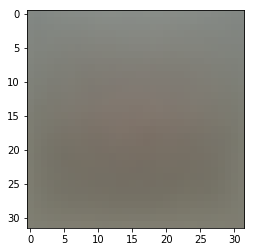

(7000, 3073) (1000, 3073) (1000, 3073)


In [34]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [35]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.370748
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [36]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.925048 analytic: 0.925043, relative error: 2.760759e-06
numerical: 0.533739 analytic: 0.533734, relative error: 4.871747e-06
numerical: -1.350675 analytic: -1.350681, relative error: 2.220620e-06
numerical: 3.003475 analytic: 3.003472, relative error: 5.298061e-07
numerical: 0.417367 analytic: 0.417363, relative error: 4.318048e-06
numerical: 0.878153 analytic: 0.878150, relative error: 1.691644e-06
numerical: 4.749063 analytic: 4.749059, relative error: 4.676377e-07
numerical: 5.012748 analytic: 5.012745, relative error: 3.253670e-07
numerical: 1.488104 analytic: 1.488100, relative error: 1.532473e-06
numerical: 2.974390 analytic: 2.974383, relative error: 1.129024e-06
numerical: 4.254599 analytic: 4.254595, relative error: 4.537027e-07
numerical: 4.171567 analytic: 4.171562, relative error: 5.546789e-07
numerical: 3.743581 analytic: 3.743577, relative error: 5.098229e-07
numerical: 1.387926 analytic: 1.387922, relative error: 1.475316e-06
numerical: -3.646354 analytic: -

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [37]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.370748e+00 computed in 0.300041s
vectorized loss: -4.608744e-03 computed in 0.403238s
Loss difference: 2.375356
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [38]:
from scripts.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 782.734203
iteration 100 / 1500: loss 286.411192
iteration 200 / 1500: loss 104.875640
iteration 300 / 1500: loss 38.438794
iteration 400 / 1500: loss 14.122634
iteration 500 / 1500: loss 5.219944
iteration 600 / 1500: loss 1.960132
iteration 700 / 1500: loss 0.767697
iteration 800 / 1500: loss 0.331739
iteration 900 / 1500: loss 0.169764
iteration 1000 / 1500: loss 0.111964
iteration 1100 / 1500: loss 0.090416
iteration 1200 / 1500: loss 0.081914
iteration 1300 / 1500: loss 0.077299
iteration 1400 / 1500: loss 0.078786
That took 22.250942s


3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [39]:
# классификатор был обучен на предыдущем шаге, посмотрим результаты
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.340143
validation accuracy: 0.333000


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

* Примечание: При использовании lr=5e-5 решение начинало расходиться, что повергало меня в неистовое уныние. 
* Поэтому для перебора параметров были использованы lr 1e-7  и 5e-6.


In [40]:
learning_rates = [1e-7, 5e-6]
regularization_strengths = [2.5e4, 5e4]

X = np.vstack([X_train, X_val])
y = np.hstack([y_train, y_val])

num_folds = 5
x_train_folds = np.array_split(X, num_folds)
y_train_folds = np.array_split(y, num_folds)

soft_results = np.zeros((len(learning_rates), len(regularization_strengths), num_folds))

best_soft_params = {'lr': 0, 'reg': 0}
best_soft_score = -1

for j, lr_rt in enumerate(learning_rates):
    for k, reg_st in enumerate(regularization_strengths):
        for i in range(num_folds):
            x_test_fold = x_train_folds[i]
            y_test_fold = y_train_folds[i]

            x_train_fold = np.concatenate(x_train_folds[:i]+x_train_folds[i+1:])
            y_train_fold = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
            
            softmax = Softmax()
            hist_loss = softmax.train(x_train_fold, y_train_fold, learning_rate=lr_rt, reg=reg_st, num_iters=500, verbose=False)

            acc = np.mean(y_test_fold == softmax.predict(x_test_fold))

            soft_results[j, k, i] = acc
            
        if np.mean(soft_results[j, k]) > best_soft_score:
            best_soft_params['lr'] = lr_rt
            best_soft_params['reg'] = reg_st
            best_soft_score = np.mean(soft_results[j, k])

In [41]:
best_soft_params

{'lr': 1e-07, 'reg': 25000.0}

In [42]:
best_soft_score

0.307875

In [43]:
softmax = Softmax()
_ = softmax.train(X_train, y_train, learning_rate=best_soft_params['lr'], reg=best_soft_params['reg'], num_iters=1500, verbose=True)


iteration 0 / 1500: loss 758.424460
iteration 100 / 1500: loss 277.612222
iteration 200 / 1500: loss 101.663088
iteration 300 / 1500: loss 37.266348
iteration 400 / 1500: loss 13.694593
iteration 500 / 1500: loss 5.065259
iteration 600 / 1500: loss 1.903307
iteration 700 / 1500: loss 0.746920
iteration 800 / 1500: loss 0.322128
iteration 900 / 1500: loss 0.166505
iteration 1000 / 1500: loss 0.108529
iteration 1100 / 1500: loss 0.088904
iteration 1200 / 1500: loss 0.081761
iteration 1300 / 1500: loss 0.079464
iteration 1400 / 1500: loss 0.077456


In [44]:
y_pred = softmax.predict(X_test)
print('test accuracy: %f' % (np.mean(y_test == y_pred), ))

test accuracy: 0.349000


* В какой-то момент мне показалось, что тот подбор параметров, который сделала я, выглядит как-то странно. Решила переделать.

In [45]:
learning_rates = [1e-7, 5e-6]
regularization_strengths = [2.5e4, 5e4]

num_folds = 5

soft_results1 = np.zeros((len(learning_rates), len(regularization_strengths)))

best_soft_params1 = {'lr': 0, 'reg': 0}
best_soft_score1 = -1

hist_losses = []
lrs = []
regs = []

for j, lr_rt in enumerate(learning_rates):
    for k, reg_st in enumerate(regularization_strengths):
            
        softmax = Softmax()
        hist_loss = softmax.train(X_train, y_train, learning_rate=lr_rt, reg=reg_st, num_iters=500, verbose=False)
        acc = np.mean(y_val == softmax.predict(X_val))

        soft_results[j, k] = acc

        if acc > best_soft_score1:
            best_soft_params1['lr'] = lr_rt
            best_soft_params1['reg'] = reg_st
            best_soft_score1 = acc
            
        hist_losses.append(hist_loss)
        lrs.append(lr_rt)
        regs.append(reg_st)

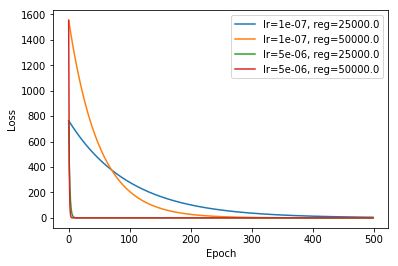

In [46]:
# графики потерь для разных параметров
for hist_loss, lr, reg in zip(hist_losses, lrs, regs):
    plt.plot(range(500), hist_loss, label='lr={}, reg={}'.format(lr, reg))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [47]:
best_soft_params1

{'lr': 1e-07, 'reg': 25000.0}

In [48]:
softmax = Softmax()
_ = softmax.train(X_train, y_train, learning_rate=best_soft_params1['lr'], reg=best_soft_params1['reg'], num_iters=1500, verbose=True)


iteration 0 / 1500: loss 771.985064
iteration 100 / 1500: loss 282.535590
iteration 200 / 1500: loss 103.455446
iteration 300 / 1500: loss 37.915316
iteration 400 / 1500: loss 13.930526
iteration 500 / 1500: loss 5.149236
iteration 600 / 1500: loss 1.935602
iteration 700 / 1500: loss 0.758423
iteration 800 / 1500: loss 0.326353
iteration 900 / 1500: loss 0.168070
iteration 1000 / 1500: loss 0.109692
iteration 1100 / 1500: loss 0.089287
iteration 1200 / 1500: loss 0.081630
iteration 1300 / 1500: loss 0.078267
iteration 1400 / 1500: loss 0.077198


In [49]:
y_pred = softmax.predict(X_test)
print('test accuracy: %f' % (np.mean(y_test == y_pred), ))

test accuracy: 0.327000


3.10 Сделайте выводы по третьей части задания

Softmax также дал прирост точности по сравнению с KNN, но оказался немного хуже SVM на тестовой выборке. 

Кросс-валидация позволяет подобрать оптимальные параметры классификатора и получить наилушие возможные результаты.

А ещё softmax векторизовать попроще, чем SVM (по моим субъективным ощущениям, или я на стадии SVM набила шишки).

Несмотря ни на что, простые алгоритмы многоклассовой классификации не слишком хорошо показывают себя на изображениях (даже 35% - не фантастический результат). 

Это связано с тем, что мы рассматриваем каждый пиксель изображения как отдельный признак, а это не всегда даёт хорошие результаты (в реальной жизни объекты одной категории могут выглядеть весьма разнообразно и даже располагаться в разных частях кадра). 

Поэтому широко используются свёртки, они позволяют вычленять признаки объектов на изображении.